In [1]:
#하이퍼파라미터
import torch
EPOCH = 5
BATCH_SIZE = 64
USE_CUDA = torch.cuda.is_available()
DEVICE = torch.device("cuda" if USE_CUDA else "cpu")
DEVICE

device(type='cuda')

In [2]:
#Fashion MNIST 데이터셋
from torchvision import transforms, datasets
trainset = datasets.FashionMNIST(
    root = 'c:/data/',
    train = True,
    download = True,
    transform = transforms.ToTensor()
)
train_loader = torch.utils.data.DataLoader(
    dataset = trainset,
    batch_size = BATCH_SIZE,
    shuffle = True,
    num_workers = 2
)

In [3]:
from torch import nn, optim
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        # 784 => 3차원 압축
        self.encoder = nn.Sequential(
            nn.Linear(28*28, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 12),
            nn.ReLU(),
            nn.Linear(12, 3),
        )

        # 3 => 784 복원
        self.decoder = nn.Sequential(
            nn.Linear(3, 12),
            nn.ReLU(),
            nn.Linear(12, 64),
            nn.ReLU(),
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.Linear(128, 28*28),
            nn.Sigmoid(),
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return encoded, decoded

In [4]:
autoencoder = Autoencoder().to(DEVICE)
optimizer = torch.optim.Adam(autoencoder.parameters(), lr=0.005)
criterion = nn.MSELoss()

In [5]:
def add_noise(img):
    noise = torch.randn(img.size()) * 0.2
    noisy_img = img + noise
    return noisy_img

In [7]:
def train(autoencoder, train_loader):
    autoencoder.train()
    avg_loss = 0
    for step, (x, label) in enumerate(train_loader):
        x = add_noise(x) # 노이즈 추가
        x = x.view(-1, 28*28).to(DEVICE)
        y = x.view(-1, 28*28).to(DEVICE)

        label = label.to(DEVICE)
        encoded, decoded = autoencoder(x)
        loss = criterion(decoded, y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        avg_loss += loss.item()
    return avg_loss / len(train_loader)

In [8]:
for epoch in range(1, EPOCH + 1):
    loss = train(autoencoder, train_loader)
    print('[Epoch {}] loss: {}'.format(epoch, loss))

[Epoch 1] loss: 0.08030483941597216
[Epoch 2] loss: 0.06650494236046317
[Epoch 3] loss: 0.06499239966781663
[Epoch 4] loss: 0.06432508528312005
[Epoch 5] loss: 0.06389449085238011


In [9]:
testset = datasets.FashionMNIST(
    root = 'c:/data',
    train = False,
    download = True,
    transform = transforms.ToTensor()
)
sample_data = testset.data[0].view(-1, 28*28)
sample_data = sample_data.type(torch.FloatTensor) / 255.
original_x = sample_data[0]
noisy_x = add_noise(original_x).to(DEVICE) # 노이즈 추가
_, recovered_x = autoencoder(noisy_x)

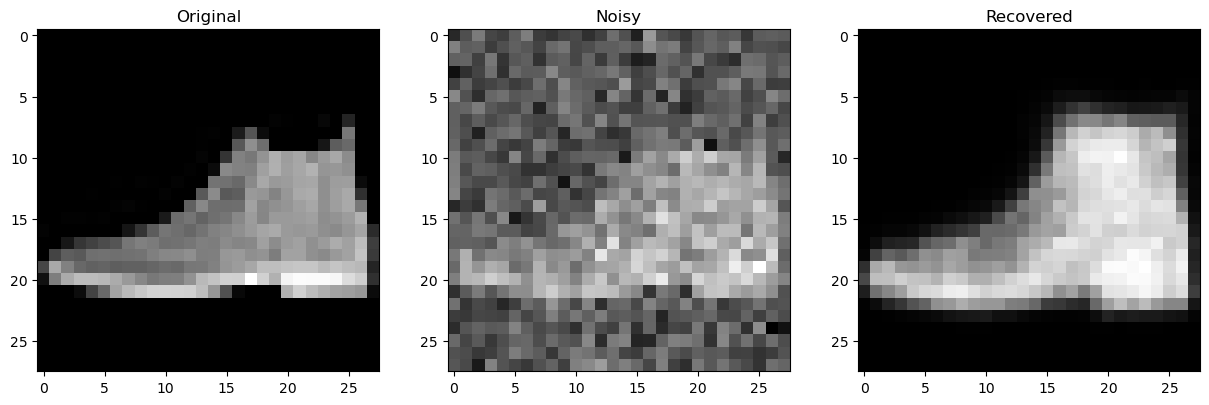

In [10]:
import matplotlib.pyplot as plt
import numpy as np
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'
f, a = plt.subplots(1, 3, figsize=(15,15))
original_img = np.reshape(original_x.to("cpu").data.numpy(), (28,28))
noisy_img = np.reshape(noisy_x.to("cpu").data.numpy(), (28,28))
recovered_img = np.reshape(recovered_x.to("cpu").data.numpy(), (28,28))
a[0].set_title('Original')
a[0].imshow(original_img, cmap='gray')
a[1].set_title('Noisy')
a[1].imshow(noisy_img, cmap='gray')
a[2].set_title('Recovered')
a[2].imshow(recovered_img, cmap='gray')
plt.show()